<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))


def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

     |████████████████████████████████| 276kB 4.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=c8e94d91bf8053e88927860470b6835b083d5a95df6f6fedf5061fe47f830794
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


## 성립 실험을 위한 시뮬레이션 데이터 생성

극단적인 power law 형태의 distribution을 시뮬레이션 한다.


<img src='https://miro.medium.com/max/2704/1*FLyS1quRikOyL_-dCA73yg.png' width='500'/>


In [2]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate + 99

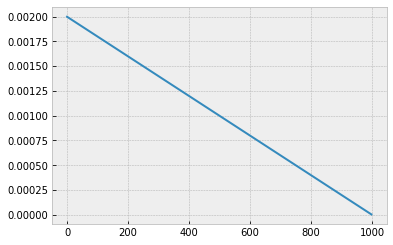

In [14]:
# random choice의 provability distribution
p = [1000-i for i in range(1000-1)]
p = p/np.sum(p)
plt.plot(p)

In [164]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,2520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = int((np.random.choice(range(1,1000),p=p)/10)**6/100000 + 100)
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [220]:
dataset = create_samples(n_samples=100)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,192,0.12,122.04
1,1000,20115,0.12,2512.80
2,1000,103,0.12,111.36
3,1000,324,0.12,137.88
4,1000,684,0.12,181.08
...,...,...,...,...
392803,2519,500,0.34,269.00
392804,2519,233,0.34,178.22
392805,2519,69744,0.34,23811.96
392806,2519,100,0.34,133.00


## 성립 데이터 EDA

In [221]:
dataset = dataset.astype({"CODE": object})
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,392808.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,2274.0,499.0
REAL_YY,int64,392808.0,0,357117.767994,987163.517993,100.00,157.00,6298.00,156350.00,9940249.00,NaN,NaN,NaN
COM_RATE,float64,392808.0,0,0.489699,0.292374,0.01,0.22,0.48,0.75,0.99,NaN,NaN,NaN
NAFYC,float64,392808.0,0,175531.791082,573632.147138,100.00,187.00,2308.74,57571.37,9606885.75,NaN,NaN,NaN


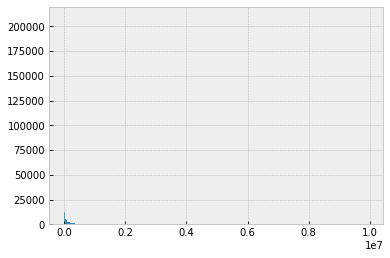

In [224]:
# 극단적인 power law 형태 확인  
dataset['REAL_YY'].hist(bins=1000)

## 데이터 전처리

In [310]:
def data_preprocess(ds1):
  # zscore norm
  ds = ds1.copy()

  dst = ds[['REAL_YY','COM_RATE']]

  _mean = dst.mean(axis=0)
  _std = dst.std(axis=0)

  dst = dst - _mean
  dst /= _std

  ds.update(dst)

  # code mapping
  code_mapping = EmbeddingMapping(ds['CODE'])
  ds = ds.assign(code_mapping=ds['CODE'].apply(code_mapping.get_mapping))

  # trainset과 validationset 나누고... 기타 정리

  X_train_org, X_val_org, Y_train, Y_val = train_test_split(ds[['REAL_YY','code_mapping']],
      ds['NAFYC'], test_size=0.1, random_state=0)

  # 학습 대상 변수만 선택
  X_train_continuous = X_train_org[['REAL_YY']]
  X_train_categorical = X_train_org[['code_mapping']]

  X_val_continuous  = X_val_org[['REAL_YY']]
  X_val_categorical = X_val_org[['code_mapping']]
  return X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val

X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val = data_preprocess(dataset)

## Network 구성

In [311]:

def model_build(X_train_continuous,X_train_categorical): 
    # Define the embedding input
    code_input = Input(shape=(1,), dtype='int32') 
    output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
    code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
    code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

    # Define the continuous variables input (just like before)
    continuous_input = Input(shape=(X_train_continuous.shape[1], ))

    # Concatenate continuous and embeddings inputs
    all_input = keras.layers.concatenate([continuous_input, code_embedings])
    print(all_input)

    # Define the model
    dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
    dense2 = Dense(5, activation='relu')(dense1)
    predictions = Dense(1)(dense2)

    # Note using the input object 'area_input' not 'area_embeddings'
    model = Model(inputs=[continuous_input, code_input], outputs=predictions)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
    model.summary()
    return model

model = model_build(X_train_continuous,X_train_categorical)

Tensor("concatenate_55/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_126"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_55 (Embedding)        (None, 1, 64)        97344       input_111[0][0]                  
__________________________________________________________________________________________________
input_112 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_55 (Reshape)            (None, 64)           0           embedding_55[0][0]               
__________________

## 학습

Epoch: 10 - {'loss': 1283072000.0, 'soft_5perc_acc': 0.09485331177711487, 'soft_10perc_acc': 0.15990692377090454, 'soft_500_acc': 0.03399031609296799, 'soft_1000_acc': 0.04904448240995407, 'soft_10000_acc': 0.3597641885280609, 'r2': 0.9960919618606567, 'val_loss': 2106346368.0, 'val_soft_5perc_acc': 0.12206757813692093, 'val_soft_10perc_acc': 0.1860201358795166, 'val_soft_500_acc': 0.03770444542169571, 'val_soft_1000_acc': 0.05481044948101044, 'val_soft_10000_acc': 0.42535191774368286, 'val_r2': 0.9933684468269348}
Epoch: 20 - {'loss': 466120320.0, 'soft_5perc_acc': 0.13888148963451385, 'soft_10perc_acc': 0.2037428915500641, 'soft_500_acc': 0.1966998130083084, 'soft_1000_acc': 0.24241188168525696, 'soft_10000_acc': 0.6236486434936523, 'r2': 0.9985930323600769, 'val_loss': 1602266752.0, 'val_soft_5perc_acc': 0.135074645280838, 'val_soft_10perc_acc': 0.21616169810295105, 'val_soft_500_acc': 0.24085909128189087, 'val_soft_1000_acc': 0.29983943700790405, 'val_soft_10000_acc': 0.71002835035

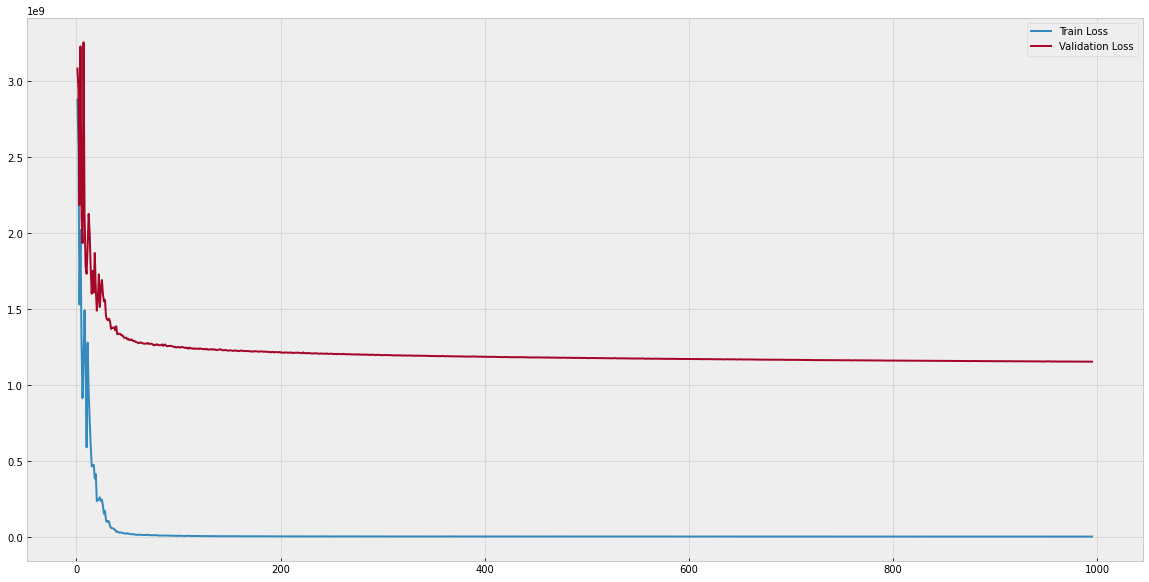

In [312]:
def train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train, Y_val, epochs = 200):
  # Note continuous and categorical columns are inserted in the same order as defined in all_inputs
  history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
            epochs=epochs, batch_size=10000, 
            callbacks=[periodic_logger_10], verbose=0,
            validation_data=([X_val_continuous, X_val_categorical], Y_val))
  # Plot the train/validation loss values
  plt.figure(figsize=(20,10))
  _loss = history.history['loss'][5:]
  _val_loss = history.history['val_loss'][5:]

  train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
  val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

  _ = plt.legend(handles=[train_loss_plot, val_loss_plot])
  return model

train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train,Y_val, epochs = 1000)

## 전략의 변경

상대오차 (5%, 10%)는 50%를 넘기지 못하면서, 절대오차 (10000원)은 99% 이상을 보이는 현상은 NAFYC가 극단적인 power law distribution을 갖기 떄문이다.
따라서, 전체 데이터를 한번에 학습하는 것이 아니라 구간별로 나누어 학습하는 방법으로 전략을 변경한다.
이를 통해, 각 구간에서 극단적인 power law 분포를 회피하도록 한다.

## 4개 구간별 학습

1구간 : 100만원 이상<br>
2구간 : 10 ~ 100만원<br>
3구간 : 1 ~ 10만원<br>
4구간 : 1만원이하<br>



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4451d57b8>,
      dtype=object)

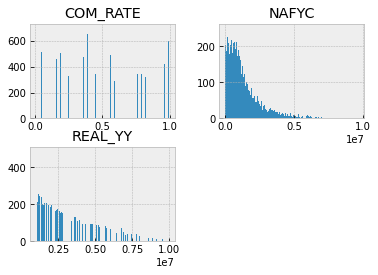

In [353]:
# 1구간
ds_e6 = dataset[dataset['REAL_YY'] > 1000000]
ds_e6.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb44e140f28>,
      dtype=object)

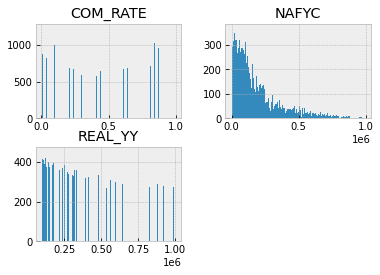

In [314]:
# 2구간
ds_e5 = dataset[(dataset['REAL_YY'] > 100000) & (dataset['REAL_YY'] <= 1000000)]
ds_e5.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb43b709390>,
      dtype=object)

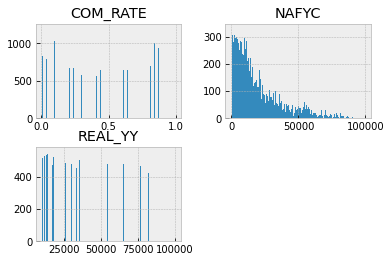

In [321]:
# 3구간
ds_e4 = dataset[(dataset['REAL_YY'] > 10000) & (dataset['REAL_YY'] <= 100000)]
ds_e4.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb438229358>,
      dtype=object)

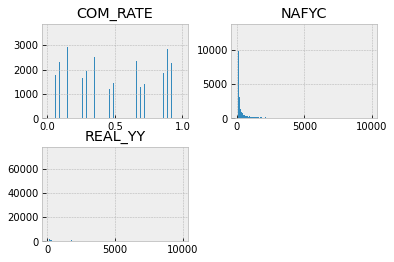

In [322]:
# 4구간
ds_e1 = dataset[dataset['REAL_YY'] <= 10000]
ds_e1.hist(bins=1000)

In [324]:
print('1구간(100만이상) 비율:',ds_e6.shape[0]/dataset.shape[0])
print('2구간( 10만이상) 비율:',ds_e5.shape[0]/dataset.shape[0])
print('3구간(  1만이상) 비율:',ds_e4.shape[0]/dataset.shape[0])
print('4구간(  1만이하) 비율:',ds_e1.shape[0]/dataset.shape[0])

1구간(100만이상) 비율: 0.10116138164192175
2구간( 10만이상) 비율: 0.18475183804810494
3구간(  1만이상) 비율: 0.18152888943198714
4구간(  1만이하) 비율: 0.5325578908779862


Tensor("concatenate_69/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_154"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_139 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 1, 64)        96384       input_139[0][0]                  
__________________________________________________________________________________________________
input_140 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_69 (Reshape)            (None, 64)           0           embedding_69[0][0]               
__________________

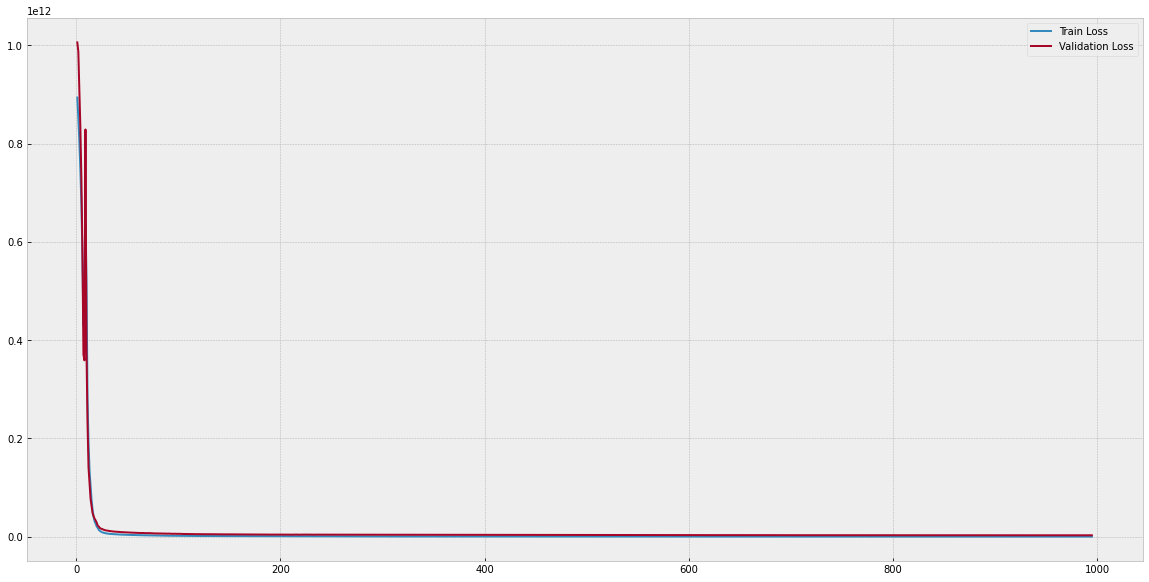

In [354]:
# 1구간 학습

#ds_e6['NAFYC'] = ds_e6['NAFYC'] / 100
X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6 = data_preprocess(ds_e6)
model_e6 = model_build(X_train_continuous,X_train_categorical)
model_build_e6 = train_model(model_e6,X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6,epochs = 1000)

Tensor("concatenate_57/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_130"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, 1, 64)        97344       input_115[0][0]                  
__________________________________________________________________________________________________
input_116 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_57 (Reshape)            (None, 64)           0           embedding_57[0][0]               
__________________

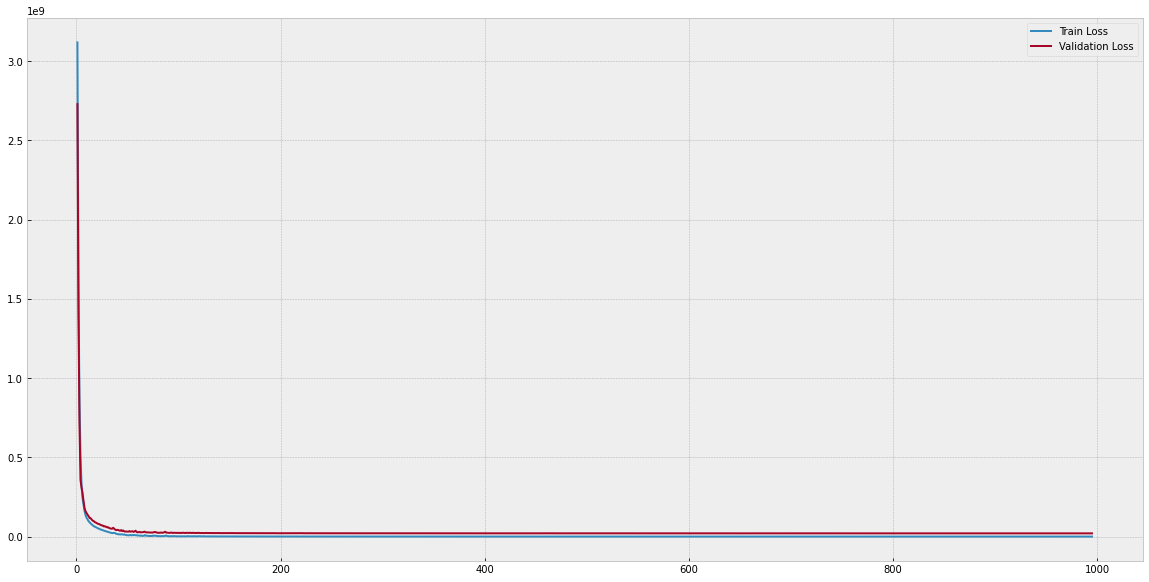

In [319]:
# 2구간 ( 10만원 이상)의 학습
X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5 = data_preprocess(ds_e5)
model_e5 = model_build(X_train_continuous,X_train_categorical)
model_build_e5 = train_model(model_e5,X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5,epochs = 1000)

Tensor("concatenate_60/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_136"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_60 (Embedding)        (None, 1, 64)        97216       input_121[0][0]                  
__________________________________________________________________________________________________
input_122 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_60 (Reshape)            (None, 64)           0           embedding_60[0][0]               
__________________

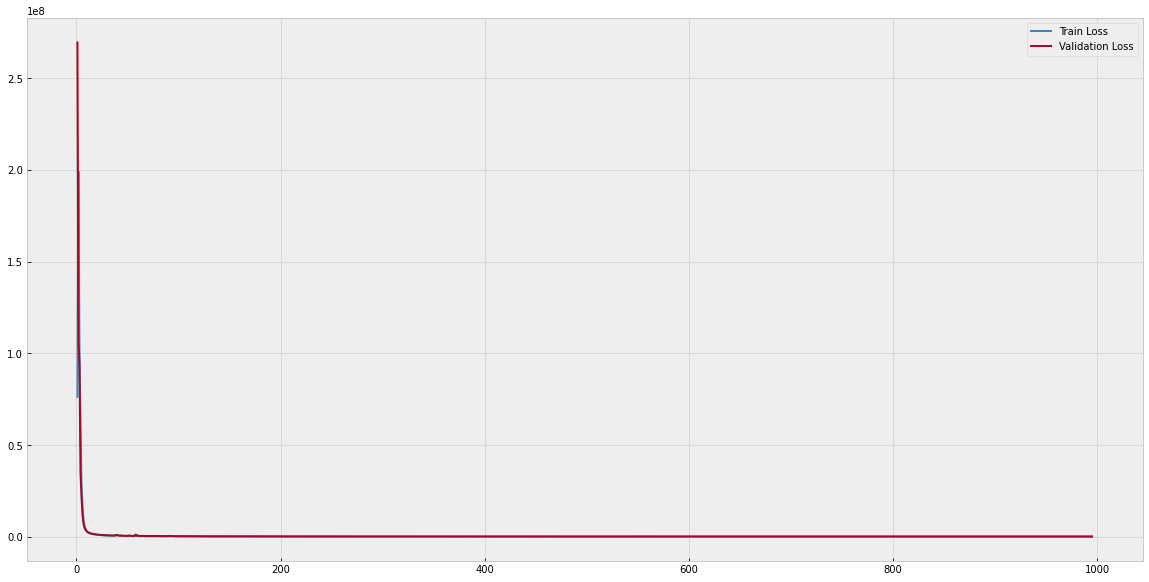

In [325]:
# 3구간 ( 1만원 이상)의 학습

X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4 = data_preprocess(ds_e4)
model_e4 = model_build(X_train_continuous,X_train_categorical)
model_build_e4 = train_model(model_e4,X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4,epochs = 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Tensor("concatenate_61/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_138"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_123 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 1, 64)        97344       input_123[0][0]                  
__________________________________________________________________________________________________
input_124 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_61 (Reshape)            (None, 64)           0           embedding_61[0][0]               
__________________

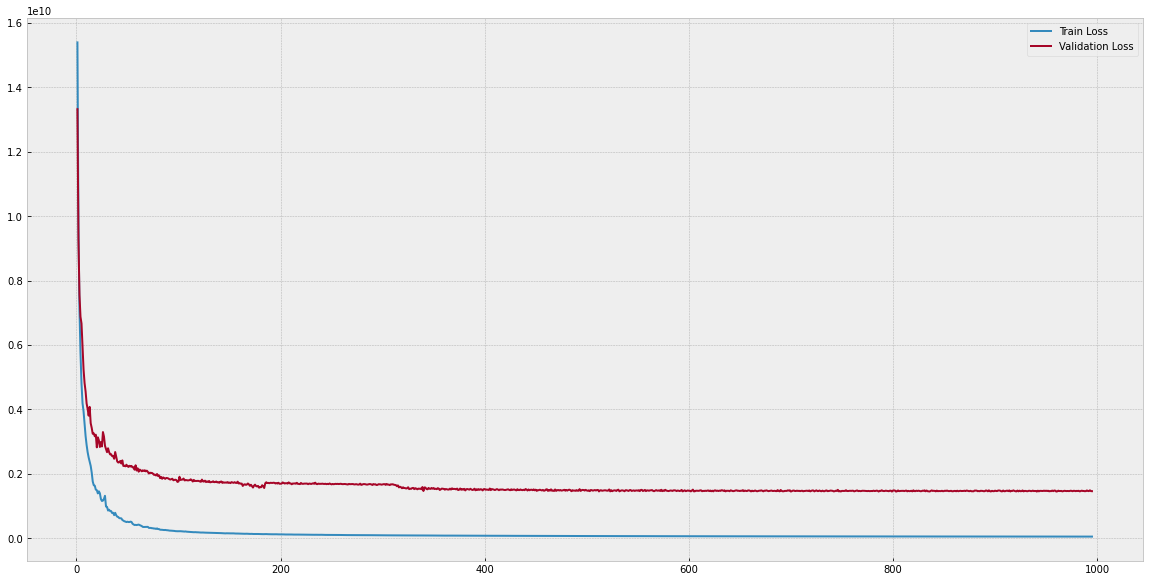

In [326]:
# 4구간 ( 1만원 이하)의 학습

# 전처리 추가
ds_e1['NAFYC'] = ds_e1['NAFYC'] * 1000

X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1 = data_preprocess(ds_e1)
model_e1 = model_build(X_train_continuous,X_train_categorical)
model_build_e1 = train_model(model_e1,X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1,epochs = 1000)

## 4개 구간 전체적인 Evaluation

In [356]:
def range_eveluation(rng,X_val_continuous, X_val_categorical,Y_val,model,adjust_weight=1.0):
    df = pd.DataFrame(Y_val,columns=['NAFYC'])
    df['NAFYC'] = df['NAFYC'] * adjust_weight
    print (str(rng) + "구간 평균 NAFYC: %d" % df['NAFYC'].mean())
    # Add a column for the model's predicted values
    df['pred'] = model.predict([X_val_continuous, X_val_categorical])
    df['pred'] = df['pred'] * adjust_weight
    # Calculate the difference between the predicted and the actual price
    df['diff'] = df['pred'] - df['NAFYC']
    # Calculate the absolute difference between the predicted and the actual price
    df['abs_diff'] = np.abs(df['diff'])
    # Calculate the percentage of the difference from the actual price
    df['%diff'] = 100 * (df['diff'] / df['NAFYC'])
    # Calculate the absolute percentage difference from the actual price
    df['abs_%diff'] = np.abs(df['%diff'])
    # Calculate the mean and std. of the diff field
    diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
    print(str(rng) + "구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
    print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
    return df

df1 = range_eveluation(1,X_val_continuous_e6, X_val_categorical_e6,Y_val_e6,model_build_e6)    
df1.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

1구간 평균 NAFYC: 1403144
1구간 오차평균 (2692.8) 표준편차 51894.99.
5% 오차내 정확도  0.9328132863613487


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
35419,1865266.50,2.142691e+02,-1.865052e+06,1.865052e+06,-99.988513,99.988513
119972,187307.88,2.142691e+02,-1.870936e+05,1.870936e+05,-99.885606,99.885606
347827,10431.02,1.946507e+04,9.034046e+03,9.034046e+03,86.607507,86.607507
221267,255577.64,4.725418e+05,2.169641e+05,2.169641e+05,84.891676,84.891676
334502,1121145.67,2.070247e+06,9.491015e+05,9.491015e+05,84.654606,84.654606
89995,364975.27,6.315629e+05,2.665877e+05,2.665877e+05,73.042666,73.042666
31603,1282044.06,2.146397e+06,8.643529e+05,8.643529e+05,67.419909,67.419909
222693,11272.66,1.831165e+04,7.038994e+03,7.038994e+03,62.443064,62.443064
280754,20403.70,3.294265e+04,1.253895e+04,1.253895e+04,61.454307,61.454307
107603,20403.70,3.249590e+04,1.209220e+04,1.209220e+04,59.264743,59.264743


In [357]:
df2 = range_eveluation(2,X_val_continuous_e5, X_val_categorical_e5,Y_val_e5,model_build_e5)    
df2.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

2구간 평균 NAFYC: 191359
2구간 오차평균 (82.66) 표준편차 4533.6.
5% 오차내 정확도  0.9899421328189584


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
136918,37269.36,96110.585938,58841.225937,58841.225937,157.880967,157.880967
117072,22941.38,38.629936,-22902.750064,22902.750064,-99.831615,99.831615
340540,504885.48,168995.140625,-335890.339375,335890.339375,-66.528025,66.528025
228545,81079.13,117651.773438,36572.643437,36572.643437,45.107346,45.107346
144527,231192.60,321226.250000,90033.650000,90033.650000,38.943137,38.943137
266729,1150.69,1513.274048,362.584048,362.584048,31.510142,31.510142
302376,2516.70,3208.217285,691.517285,691.517285,27.477144,27.477144
302061,2516.70,3208.217285,691.517285,691.517285,27.477144,27.477144
107808,273943.20,337435.875000,63492.675000,63492.675000,23.177314,23.177314
314935,93180.48,114644.406250,21463.926250,21463.926250,23.034788,23.034788


In [358]:
df3 = range_eveluation(3,X_val_continuous_e4, X_val_categorical_e4,Y_val_e4,model_build_e4)    
df3.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

3구간 평균 NAFYC: 19687
3구간 오차평균 (-21.16) 표준편차 465.37.
5% 오차내 정확도  0.9697097181320993


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
239574,1072.41,4316.881836,3244.471836,3244.471836,302.540244,302.540244
341246,21004.92,42.969326,-20961.950674,20961.950674,-99.795432,99.795432
71760,17754.80,42.969326,-17711.830674,17711.830674,-99.757985,99.757985
181227,7384.23,42.969326,-7341.260674,7341.260674,-99.418093,99.418093
341252,4930.96,42.969326,-4887.990674,4887.990674,-99.128581,99.128581
135136,4914.58,42.969326,-4871.610674,4871.610674,-99.125677,99.125677
341249,3366.04,42.969326,-3323.070674,3323.070674,-98.723446,98.723446
123107,3214.62,42.969326,-3171.650674,3171.650674,-98.663316,98.663316
118697,2771.00,42.969326,-2728.030674,2728.030674,-98.449321,98.449321
374793,2479.05,42.969326,-2436.080674,2436.080674,-98.266702,98.266702


In [359]:
df4 = range_eveluation(4,X_val_continuous_e1, X_val_categorical_e1,Y_val_e1,model_build_e1,adjust_weight=0.001)    
df4.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

4구간 평균 NAFYC: 741
4구간 오차평균 (-0.29) 표준편차 38.17.
5% 오차내 정확도  0.9948374760994264


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
200564,230.14,1308.600250,1078.460250,1078.460250,468.610520,468.610520
345801,3033.90,861.953688,-2171.946313,2171.946313,-71.589252,71.589252
345796,7153.20,2471.616500,-4681.583500,4681.583500,-65.447401,65.447401
225577,842.04,303.168125,-538.871875,538.871875,-63.995995,63.995995
376841,1526.20,779.720688,-746.479312,746.479312,-48.910976,48.910976
183327,238.44,353.929500,115.489500,115.489500,48.435455,48.435455
225585,286.48,202.240625,-84.239375,84.239375,-29.404976,29.404976
31882,184.00,233.286000,49.286000,49.286000,26.785870,26.785870
31901,184.00,233.286000,49.286000,49.286000,26.785870,26.785870
31895,184.00,233.286000,49.286000,49.286000,26.785870,26.785870


In [360]:
df = pd.concat([df1,df2,df3,df4])
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("전체 구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("1% 오차내 정확도 ",1- df[df['abs_%diff'] > 1]['abs_%diff'].count()/df['abs_%diff'].count())
print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
print("10% 오차내 정확도 ",1- df[df['abs_%diff'] > 10]['abs_%diff'].count()/df['abs_%diff'].count())


전체 구간 오차평균 (283.69) 표준편차 16639.47.
1% 오차내 정확도  0.6572817758317848
5% 오차내 정확도  0.9830970139755111
10% 오차내 정확도  0.9913448565537255


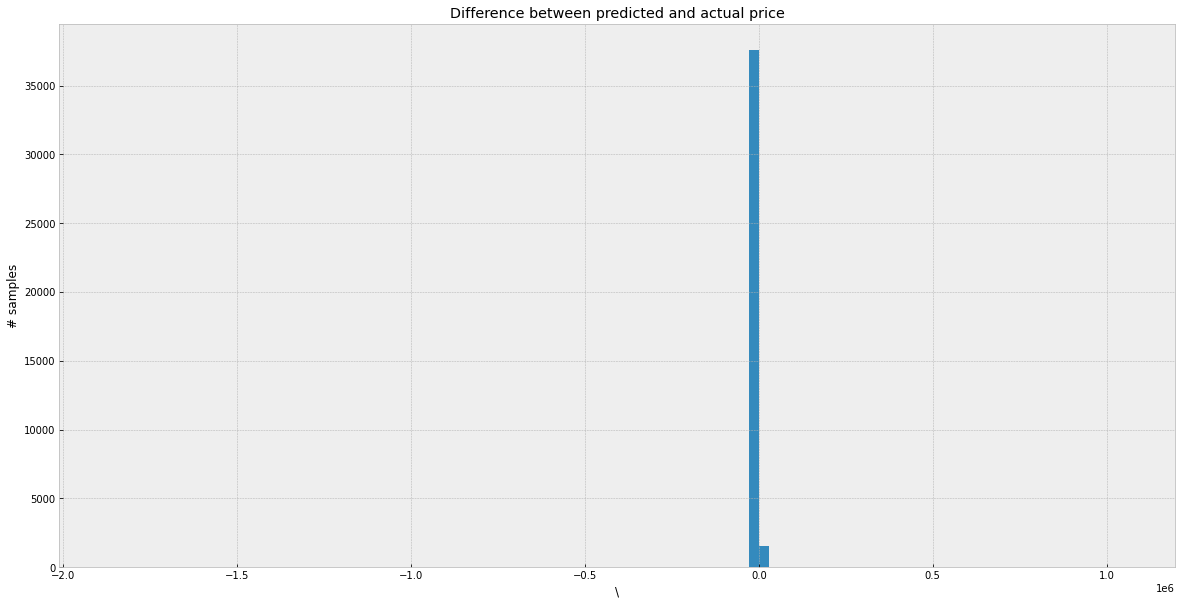

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC
200564,1308.600250,1.078460e+03,1.078460e+03,468.610520,468.610520,1769,6557,0.02,230.14
239574,4316.881836,3.244472e+03,3.244472e+03,302.540244,302.540244,1914,97341,0.01,1072.41
136918,96110.585938,5.884123e+04,5.884123e+04,157.880967,157.880967,1524,929259,0.04,37269.36
35419,214.269150,-1.865052e+06,1.865052e+06,-99.988513,99.988513,1137,2486890,0.75,1865266.50
119972,214.269150,-1.870936e+05,1.870936e+05,-99.885606,99.885606,1455,2340111,0.08,187307.88
117072,38.629936,-2.290275e+04,2.290275e+04,-99.831615,99.831615,1445,103829,0.22,22941.38
341246,42.969326,-2.096195e+04,2.096195e+04,-99.795432,99.795432,2314,74664,0.28,21004.92
71760,42.969326,-1.771183e+04,1.771183e+04,-99.757985,99.757985,1280,41060,0.43,17754.80
181227,42.969326,-7.341261e+03,7.341261e+03,-99.418093,99.418093,1698,80947,0.09,7384.23
341252,42.969326,-4.887991e+03,4.887991e+03,-99.128581,99.128581,2314,17257,0.28,4930.96


In [361]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_%diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

## Non-linearity 대응을 위한 polynomial Regression 적용
https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88